## Import

Reference: https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/ttm_getting_started.ipynb

In [28]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

## Arguments

In [35]:
# TODO:TONY - Try out r1 too
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
# Which resolution to train on (15 or 5)
RESOLUTION_MIN = 15

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
interval = f"{RESOLUTION_MIN}mins"
dir_path = f"../../models/ttm/kaggle_brisT1D/{interval}/{current_time}"
OUT_DIR = ""

## Load data

In [36]:
from src.data.diabetes_datasets.kaggle_bris_t1d.bris_t1d import BrisT1DDataLoader

loader = BrisT1DDataLoader(use_cached=True)
# TODO:TONY - Not sure why it is still processing even if use_cached is True

INFO:p-1546:t-8767966336:bris_t1d.py:load_data:============================================================
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:Beginning data loading process with the following parmeters:
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:	Dataset: kaggle_brisT1D - train
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:	Columns: None
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:	Generic patient start date: 2024-01-01 00:00:00
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:	Number of validation days: 20
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:	In parallel with up to 3 workers.

INFO:p-1546:t-8767966336:cache_manager.py:get_processed_data_path:Processed data path for kaggle_brisT1D: /Users/tonychan/GlucoseML/nocturnal-hypo-gly-prob-forecast/cache/data/kaggle_brisT1D/processed
INFO:p-1546:t-8767966336:bris_t1d.py:load_data:Loaded full processed data from cache for 9 patients
INFO:p-1546:t-8767966336:cache_manager.py:get_processed_data_path:Processed data pat

In [37]:
list(loader.train_data["p01"].columns)

['id',
 'p_num',
 'bg_mM',
 'dose_units',
 'food_g',
 'hr_bpm',
 'steps',
 'cals',
 'activity',
 'msg_type',
 'cob',
 'carb_availability',
 'insulin_availability',
 'iob']

In [49]:
from src.tuning.benchmark import impute_missing_values

y_feature = ["bg_mM"]
x_features = ["steps", "cob", "carb_availability", "insulin_availability", "iob"]
TARGET_DATASET = "p01"

# datetime is the index column...
timestamp_column = "datetime"

# exogenous features
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": y_feature,
    "control_columns": x_features,
}


def reduce_features(df):
    # Make sure index is set to datetime
    p_df = df.iloc[:]
    # p_df.set_index("datetime", inplace=True)
    # p_df = p_df.asfreq('5T', method='pad') -- Padding is NOT recommended as ttm is not designed for it.

    p_df = p_df[x_features + y_feature]

    # Impute with default methods
    p_df = impute_missing_values(p_df, columns=x_features)
    p_df = impute_missing_values(p_df, columns=y_feature)

    return p_df


data = reduce_features(loader.train_data["p01"])
# datetime has to be a column
data = data.reset_index()
data


data_length = len(data)
split_config = {
    "train": [0, int(data_length * 0.7)],  # 70% for training
    "valid": [int(data_length * 0.7), int(data_length * 0.85)],  # 15% for validation
    "test": [int(data_length * 0.85), data_length],  # 15% for testing
}

## Zero-shot fine tuning

In [52]:
import random


def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        use_frequency_token=zeroshot_model.config.resolution_prefix_tuning,
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            # seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    random.seed(42)  # For reproducibility
    test_dataset_size = len(dset_test)  # This should be 914 based on your output
    valid_indices = random.sample(range(test_dataset_size), min(10, test_dataset_size))

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=valid_indices,
        channel=0,
    )

INFO:p-1546:t-8767966336:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-1546:t-8767966336:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-1546:t-8767966336:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++
{'eval_loss': 1.0197672843933105, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.554, 'eval_samples_per_second': 1649.923, 'eval_steps_per_second': 27.078}
{'eval_loss': 1.0197672843933105, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.554, 'eval_samples_per_second': 1649.923, 'eval_steps_per_second': 27.078}
(914, 96, 6)
(914, 6, 8, 192)


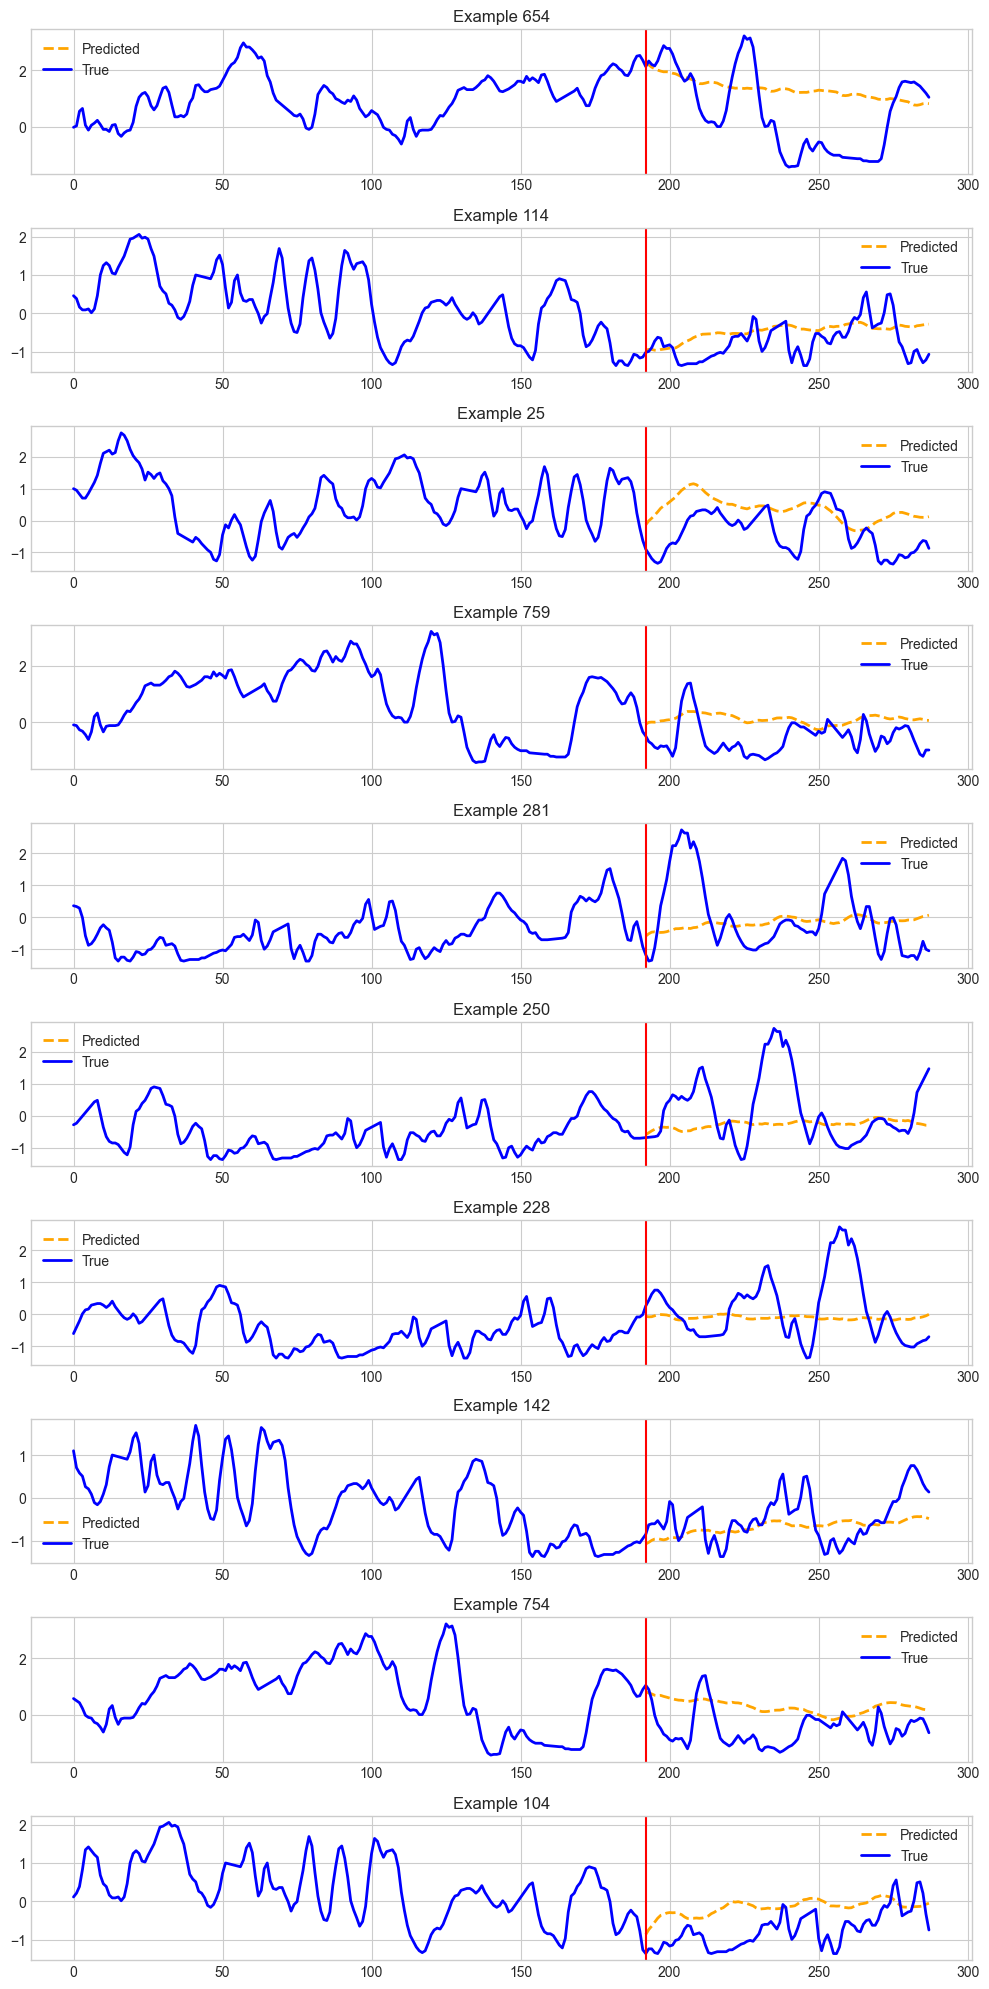

In [53]:
zeroshot_eval(
    TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
)

## Few shot settings

In [56]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(
            out_dir, "logs"
        ),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        # seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

INFO:p-1546:t-8767966336:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-1546:t-8767966336:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-1546:t-8767966336:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001
{'loss': 1.9202, 'grad_norm': 0.854164183139801, 'learning_rate': 5.122213325915845e-05, 'epoch': 1.0}
{'eval_loss': 0.9886052012443542, 'eval_runtime': 66.3464, 'eval_samples_per_second': 13.761, 'eval_steps_per_second': 0.226, 'epoch': 1.0}
{'loss': 1.9299, 'grad_norm': 0.8570234775543213, 'learning_rate': 8.436379855794054e-05, 'epoch': 2.0}
{'eval_loss': 0.9872657656669617, 'eval_runtime': 65.5397, 'eval_samples_per_second': 13.93, 'eval_steps_per_second': 0.229, 'epoch': 2.0}
{'loss': 1.9188, 'grad_norm': 0.9206507802009583, 'learning_rate': 0.00013787532846129102, 'epoch': 3.0}
